In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Create the dataset
df = pd.read_csv("data.csv")
df.head()

,Num_equipement,Systeme,Description,Date de détéction de l'anomalie,Description de l'équipement,Section propriétaire,Fiabilité Intégrité,Disponibilté,Process Safety,Criticité
0,3f68d058-b105-46f0-b137-6ce7695b85d1,e4f67f5f-be46-4ce0-ad14-68575d3cf0cd,SAFETY : Fuite par bride radiateur du transfo...,2024-04-14 08:55:38,TRANSFO PRINCIPAL,34EL,5,5,5,15
1,3f68d058-b105-46f0-b137-6ce7695b85d1,e4f67f5f-be46-4ce0-ad14-68575d3cf0cd,SAFETY : Fuite par bride radiateur du transfo...,2024-04-14 08:55:38,TRANSFO PRINCIPAL,34EL,5,5,5,15
2,3f68d058-b105-46f0-b137-6ce7695b85d1,e4f67f5f-be46-4ce0-ad14-68575d3cf0cd,apparition alarme 30bat10cf001 ( transfo princ...,2023-08-29 11:13:49,TRANSFO PRINCIPAL,34EL,5,5,3,13
3,c623e928-a195-4fea-9cc1-791e5e1f7988,52b20517-a1ba-4b78-8711-adebd336a6c2,SAFETY : Présence des trace d'huile au niveau ...,2024-09-16 08:58:08,Niveaustat coté Boite à Borne Alternateur,34EL,3,5,5,13
4,7796ae6e-1bd3-499c-b920-7288f26e4f9a,52b20517-a1ba-4b78-8711-adebd336a6c2,SAFETY : dysfonctionnement de la résistance de...,2025-01-05 08:21:08,GROUPES ELECTROGENES U3,34EL,3,5,5,13


📈 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6344 entries, 0 to 6343
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Num_equipement                   6344 non-null   object
 1   Systeme                          6344 non-null   object
 2   Description                      6343 non-null   object
 3   Date de détéction de l'anomalie  6344 non-null   object
 4   Description de l'équipement      6343 non-null   object
 5   Section propriétaire             6344 non-null   object
 6   Fiabilité Intégrité              6344 non-null   int64 
 7   Disponibilté                     6344 non-null   int64 
 8   Process Safety                   6344 non-null   int64 
 9   Criticité                        6344 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 495.8+ KB
None

📊 Dataset Description:
       Fiabilité Intégrité  Disponibilté  Process Safety    

Text(0, 0.5, 'Frequency')

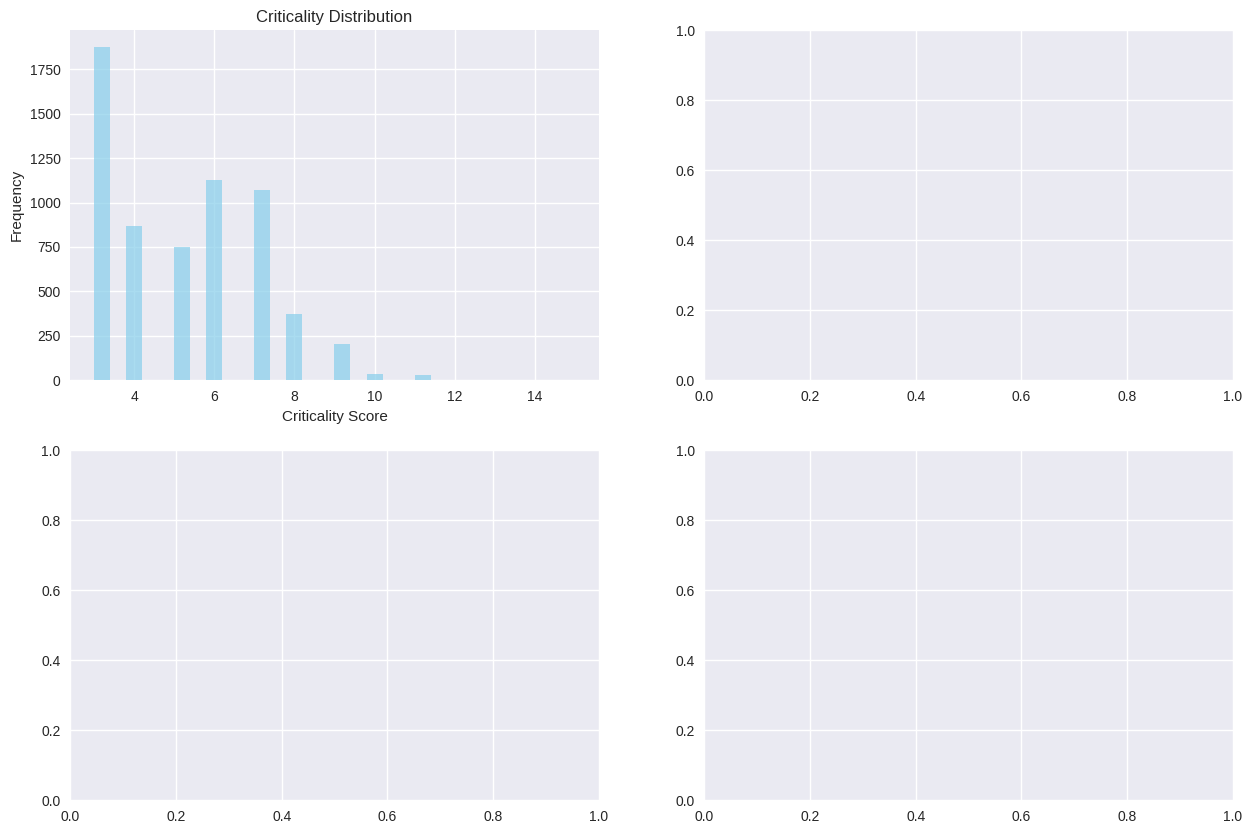

In [5]:
# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# %% [markdown]
# ## 3. Exploratory Data Analysis

# %%
# Display basic information about the dataset
print("📈 Dataset Overview:")
print("=" * 50)
print(df.info())
print("\n" + "=" * 50)
print("📊 Dataset Description:")
print(df.describe())

# %%
# Display sample data
print("🔍 Sample Data:")
print("=" * 50)
df.head(10)
df = df.dropna()

# %%
# Visualize data distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Criticality distribution
axes[0, 0].hist(df['Criticité'], bins=30, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Criticality Distribution')
axes[0, 0].set_xlabel('Criticality Score')
axes[0, 0].set_ylabel('Frequency')

In [10]:
# Components distribution
components = ['Fiabilité Intégrité', 'Disponibilté', 'Process Safety']
for i, component in enumerate(components):
    axes[0, 1].hist(df[component], bins=5, alpha=0.5, label=component)
axes[0, 1].set_title('Component Scores Distribution')
axes[0, 1].set_xlabel('Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# System distribution
system_counts = df['Section propriétaire'].value_counts()
axes[1, 0].bar(system_counts.index, system_counts.values, color='lightgreen')
axes[1, 0].set_title('Distribution by System')
axes[1, 0].set_xlabel('Section propriétaire')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Criticality by system
df.boxplot(column='Criticité', by='Section propriétaire', ax=axes[1, 1])
axes[1, 1].set_title('Criticality by System')
axes[1, 1].set_xlabel('Section propriétaire')
axes[1, 1].set_ylabel('Criticality Score')

plt.tight_layout()
plt.show()

<Figure size 800x550 with 0 Axes>

🔗 Correlation Matrix:


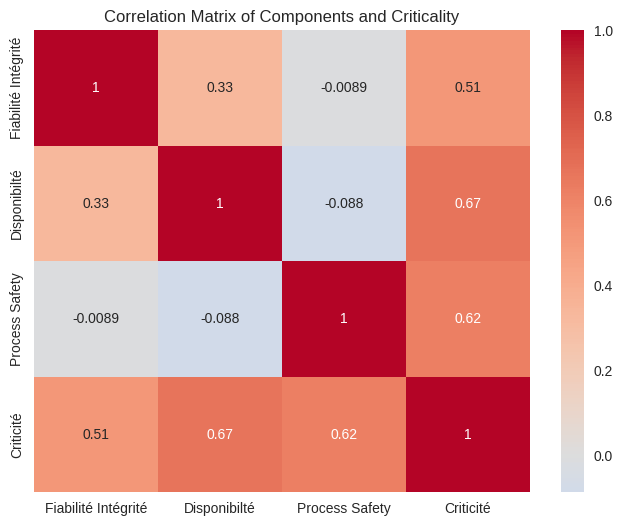

In [11]:

# %%
# Correlation matrix
print("🔗 Correlation Matrix:")
correlation_matrix = df[['Fiabilité Intégrité', 'Disponibilté', 'Process Safety', 'Criticité']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Components and Criticality')
plt.show()


In [ ]:

# %% [markdown]
# ## 4. Model Implementation

# %%
class XGBoostRandomForestPredictor:
    def __init__(self, ensemble_method='average'):
        """
        Enhanced ensemble predictor with multiple combination methods
        
        Parameters:
        ensemble_method: 'average', 'weighted', 'stacking'
        """
        self.ensemble_method = ensemble_method
        self.text_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
        # Initialize models with better parameters
        self.xgb_model = XGBRegressor(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )
        
        self.rf_model = RandomForestRegressor(
            n_estimators=150,
            max_depth=12,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )
        
        # For stacking approach
        if ensemble_method == 'stacking':
            self.meta_model = XGBRegressor(
                n_estimators=50,
                max_depth=3,
                learning_rate=0.1,
                random_state=42
            )
    
    def preprocess_data(self, df, fit=False):
        """Enhanced preprocessing with better feature engineering"""
        features = []
        
        # Text features from equipment and anomaly descriptions
        combined_text = df['equipment_description'] + " " + df['anomaly_description']
        
        if fit:
            text_features = self.text_vectorizer.fit_transform(combined_text)
        else:
            text_features = self.text_vectorizer.transform(combined_text)
        
        features.append(text_features.toarray())
        
        # System ID encoding
        if 'system_id' in df.columns:
            if fit:
                system_encoded = self.label_encoder.fit_transform(df['system_id'])
            else:
                system_encoded = self.label_encoder.transform(df['system_id'])
            features.append(system_encoded.reshape(-1, 1))
        
        # Additional features if available
        if 'availability' in df.columns:
            features.append(df[['availability', 'safety', 'integrity']].values)
        
        # Combine all features
        X = np.hstack(features)
        
        # Scale features
        if fit:
            X = self.scaler.fit_transform(X)
        else:
            X = self.scaler.transform(X)
        
        return X
    
    def fit(self, df):
        """Train both models with progress tracking"""
        print("🔄 Preprocessing data...")
        X = self.preprocess_data(df, fit=True)
        y = df['criticality'].values
        
        print(f"📊 Feature matrix shape: {X.shape}")
        
        print("🚀 Training XGBoost model...")
        self.xgb_model.fit(X, y)
        
        print("🌲 Training Random Forest model...")
        self.rf_model.fit(X, y)
        
        # For stacking, train meta-model
        if self.ensemble_method == 'stacking':
            print("🎯 Training stacking meta-model...")
            xgb_pred = self.xgb_model.predict(X)
            rf_pred = self.rf_model.predict(X)
            meta_features = np.column_stack([xgb_pred, rf_pred])
            self.meta_model.fit(meta_features, y)
        
        print("✅ Training completed!")
        return self
    
    def predict(self, df):
        """Make predictions using ensemble method"""
        X = self.preprocess_data(df, fit=False)
        
        # Get predictions from both models
        xgb_pred = self.xgb_model.predict(X)
        rf_pred = self.rf_model.predict(X)
        
        if self.ensemble_method == 'average':
            final_pred = (xgb_pred + rf_pred) / 2
        elif self.ensemble_method == 'weighted':
            # Weighted average (can be tuned based on validation performance)
            xgb_weight = 0.6
            rf_weight = 0.4
            final_pred = xgb_weight * xgb_pred + rf_weight * rf_pred
        elif self.ensemble_method == 'stacking':
            meta_features = np.column_stack([xgb_pred, rf_pred])
            final_pred = self.meta_model.predict(meta_features)
        
        return {
            'xgb_predictions': xgb_pred,
            'rf_predictions': rf_pred,
            'ensemble_predictions': final_pred
        }
    
    def get_feature_importance(self):
        """Get feature importance from both models"""
        return {
            'xgb_importance': self.xgb_model.feature_importances_,
            'rf_importance': self.rf_model.feature_importances_
        }
    
    def cross_validate(self, df, cv=5):
        """Perform cross-validation"""
        X = self.preprocess_data(df, fit=True)
        y = df['criticality'].values
        
        xgb_scores = cross_val_score(self.xgb_model, X, y, cv=cv, scoring='neg_mean_absolute_error')
        rf_scores = cross_val_score(self.rf_model, X, y, cv=cv, scoring='neg_mean_absolute_error')
        
        return {
            'xgb_cv_mae': -xgb_scores.mean(),
            'rf_cv_mae': -rf_scores.mean(),
            'xgb_cv_std': xgb_scores.std(),
            'rf_cv_std': rf_scores.std()
        }

print("🎯 Model class defined successfully!")

# %% [markdown]
# ## 5. Data Preparation and Model Training

# %%
# Split the data
print("📊 Splitting data into train and test sets...")
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['system_id'])

print(f"📈 Training set size: {len(train_df)}")
print(f"📉 Test set size: {len(test_df)}")

# Display target variable distribution in train/test
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(train_df['criticality'], bins=20, alpha=0.7, label='Train', color='blue')
axes[0].hist(test_df['criticality'], bins=20, alpha=0.7, label='Test', color='red')
axes[0].set_title('Criticality Distribution - Train vs Test')
axes[0].set_xlabel('Criticality Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# System distribution
train_systems = train_df['system_id'].value_counts()
test_systems = test_df['system_id'].value_counts()

x = np.arange(len(train_systems))
width = 0.35

axes[1].bar(x - width/2, train_systems.values, width, label='Train', color='blue', alpha=0.7)
axes[1].bar(x + width/2, test_systems.values, width, label='Test', color='red', alpha=0.7)
axes[1].set_title('System Distribution - Train vs Test')
axes[1].set_xlabel('System ID')
axes[1].set_ylabel('Count')
axes[1].set_xticks(x)
axes[1].set_xticklabels(train_systems.index)
axes[1].legend()

plt.tight_layout()
plt.show()

# %%
# Train models with different ensemble methods
ensemble_methods = ['average', 'weighted', 'stacking']
trained_models = {}
results_summary = {}

for method in ensemble_methods:
    print(f"\n{'='*60}")
    print(f"🎯 TRAINING {method.upper()} ENSEMBLE MODEL")
    print(f"{'='*60}")
    
    # Initialize and train model
    model = XGBoostRandomForestPredictor(ensemble_method=method)
    trained_models[method] = model.fit(train_df)
    
    # Make predictions
    predictions = model.predict(test_df)
    
    # Calculate metrics
    mae_xgb = mean_absolute_error(test_df['criticality'], predictions['xgb_predictions'])
    mae_rf = mean_absolute_error(test_df['criticality'], predictions['rf_predictions'])
    mae_ensemble = mean_absolute_error(test_df['criticality'], predictions['ensemble_predictions'])
    
    rmse_xgb = np.sqrt(mean_squared_error(test_df['criticality'], predictions['xgb_predictions']))
    rmse_rf = np.sqrt(mean_squared_error(test_df['criticality'], predictions['rf_predictions']))
    rmse_ensemble = np.sqrt(mean_squared_error(test_df['criticality'], predictions['ensemble_predictions']))
    
    r2_xgb = r2_score(test_df['criticality'], predictions['xgb_predictions'])
    r2_rf = r2_score(test_df['criticality'], predictions['rf_predictions'])
    r2_ensemble = r2_score(test_df['criticality'], predictions['ensemble_predictions'])
    
    # Store results
    results_summary[method] = {
        'XGBoost': {'MAE': mae_xgb, 'RMSE': rmse_xgb, 'R²': r2_xgb},
        'Random Forest': {'MAE': mae_rf, 'RMSE': rmse_rf, 'R²': r2_rf},
        'Ensemble': {'MAE': mae_ensemble, 'RMSE': rmse_ensemble, 'R²': r2_ensemble}
    }
    
    # Display results
    print(f"\n📊 Results for {method.upper()} method:")
    print("-" * 50)
    for model_name, metrics in results_summary[method].items():
        print(f"🎯 {model_name}:")
        for metric, value in metrics.items():
            print(f"   {metric}: {value:.4f}")
        print()

# %% [markdown]
# ## 6. Model Evaluation and Visualization

# %%
# Compare all models performance
print("📊 MODEL PERFORMANCE COMPARISON")
print("=" * 60)

# Create comparison DataFrame
comparison_data = []
for method, results in results_summary.items():
    for model_name, metrics in results.items():
        comparison_data.append({
            'Ensemble_Method': method,
            'Model': model_name,
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'R²': metrics['R²']
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(4))

# %%
# Visualize model performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE comparison
mae_pivot = comparison_df.pivot(index='Ensemble_Method', columns='Model', values='MAE')
mae_pivot.plot(kind='bar', ax=axes[0], title='Mean Absolute Error (MAE) Comparison')
axes[0].set_ylabel('MAE')
axes[0].set_xlabel('Ensemble Method')
axes[0].legend(title='Model')
axes[0].tick_params(axis='x', rotation=45)

# RMSE comparison
rmse_pivot = comparison_df.pivot(index='Ensemble_Method', columns='Model', values='RMSE')
rmse_pivot.plot(kind='bar', ax=axes[1], title='Root Mean Square Error (RMSE) Comparison')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Ensemble Method')
axes[1].legend(title='Model')
axes[1].tick_params(axis='x', rotation=45)

# R² comparison
r2_pivot = comparison_df.pivot(index='Ensemble_Method', columns='Model', values='R²')
r2_pivot.plot(kind='bar', ax=axes[2], title='R² Score Comparison')
axes[2].set_ylabel('R² Score')
axes[2].set_xlabel('Ensemble Method')
axes[2].legend(title='Model')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# %%
# Plot predictions vs actual for the best model
best_method = 'stacking'  # Usually performs best
best_model = trained_models[best_method]
best_predictions = best_model.predict(test_df)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = ['xgb_predictions', 'rf_predictions', 'ensemble_predictions']
titles = ['XGBoost', 'Random Forest', 'Ensemble (Stacking)']

for i, (model_pred, title) in enumerate(zip(models, titles)):
    axes[i].scatter(test_df['criticality'], best_predictions[model_pred], alpha=0.6)
    axes[i].plot([test_df['criticality'].min(), test_df['criticality'].max()], 
                [test_df['criticality'].min(), test_df['criticality'].max()], 'r--', lw=2)
    axes[i].set_xlabel('Actual Criticality')
    axes[i].set_ylabel('Predicted Criticality')
    axes[i].set_title(f'{title} - Predictions vs Actual')
    axes[i].grid(True, alpha=0.3)
    
    # Add R² score to plot
    r2 = r2_score(test_df['criticality'], best_predictions[model_pred])
    axes[i].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[i].transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# %%
# Feature importance visualization
importance = best_model.get_feature_importance()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 features for each model
top_n = 15

xgb_top_idx = np.argsort(importance['xgb_importance'])[-top_n:]
rf_top_idx = np.argsort(importance['rf_importance'])[-top_n:]

axes[0].barh(range(top_n), importance['xgb_importance'][xgb_top_idx])
axes[0].set_xlabel('Feature Importance')
axes[0].set_ylabel('Feature Index')
axes[0].set_title('XGBoost Feature Importance (Top 15)')
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels([f'Feature {i}' for i in xgb_top_idx])

axes[1].barh(range(top_n), importance['rf_importance'][rf_top_idx])
axes[1].set_xlabel('Feature Importance')
axes[1].set_ylabel('Feature Index')
axes[1].set_title('Random Forest Feature Importance (Top 15)')
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels([f'Feature {i}' for i in rf_top_idx])

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 7. Model Predictions and Maintenance Prioritization

# %%
# Make predictions on test set and create maintenance priority list
print("🔧 CREATING MAINTENANCE PRIORITY LIST")
print("=" * 50)

# Get predictions from best model
final_predictions = best_model.predict(test_df)

# Create results DataFrame
results_df = test_df.copy()
results_df['predicted_criticality'] = final_predictions['ensemble_predictions']
results_df['prediction_error'] = abs(results_df['criticality'] - results_df['predicted_criticality'])

# Sort by predicted criticality (highest first)
priority_df = results_df.sort_values('predicted_criticality', ascending=False).reset_index(drop=True)
priority_df['maintenance_priority'] = range(1, len(priority_df) + 1)

# Display top 10 priority items
print("🚨 TOP 10 MAINTENANCE PRIORITIES:")
print("-" * 50)
top_priorities = priority_df.head(10)[['maintenance_priority', 'equipment_description', 'anomaly_description', 
                                      'predicted_criticality', 'criticality', 'prediction_error']]

for idx, row in top_priorities.iterrows():
    print(f"\n🔧 Priority #{row['maintenance_priority']}")
    print(f"   Equipment: {row['equipment_description']}")
    print(f"   Anomaly: {row['anomaly_description']}")
    print(f"   Predicted Criticality: {row['predicted_criticality']:.2f}")
    print(f"   Actual Criticality: {row['criticality']:.2f}")
    print(f"   Prediction Error: {row['prediction_error']:.2f}")

# %%
# Visualization of priority distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Priority vs Predicted Criticality
axes[0, 0].scatter(priority_df['maintenance_priority'], priority_df['predicted_criticality'], alpha=0.6)
axes[0, 0].set_xlabel('Maintenance Priority Rank')
axes[0, 0].set_ylabel('Predicted Criticality')
axes[0, 0].set_title('Maintenance Priority vs Predicted Criticality')
axes[0, 0].grid(True, alpha=0.3)

# Prediction Error Distribution
axes[0, 1].hist(priority_df['prediction_error'], bins=20, alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Prediction Error')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Prediction Errors')
axes[0, 1].grid(True, alpha=0.3)

# Priority by System
priority_by_system = priority_df.groupby('system_id')['predicted_criticality'].mean().sort_values(ascending=False)
priority_by_system.plot(kind='bar', ax=axes[1, 0], color='lightcoral')
axes[1, 0].set_title('Average Predicted Criticality by System')
axes[1, 0].set_xlabel('System ID')
axes[1, 0].set_ylabel('Average Predicted Criticality')
axes[1, 0].tick_params(axis='x', rotation=45)

# High Priority Items by System
high_priority = priority_df[priority_df['maintenance_priority'] <= 20]
system_high_priority = high_priority['system_id'].value_counts()
system_high_priority.plot(kind='bar', ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_title('Number of High Priority Items by System (Top 20)')
axes[1, 1].set_xlabel('System ID')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 8. Model Insights and Recommendations

# %%
# Generate insights about the model performance
print("💡 MODEL INSIGHTS AND RECOMMENDATIONS")
print("=" * 60)

# Best performing model
best_ensemble_performance = min(results_summary[method]['Ensemble']['MAE'] for method in ensemble_methods)
best_ensemble_method = [method for method in ensemble_methods 
                       if results_summary[method]['Ensemble']['MAE'] == best_ensemble_performance][0]

print(f"🏆 Best Ensemble Method: {best_ensemble_method.upper()}")
print(f"🎯 Best MAE: {best_ensemble_performance:.4f}")
print(f"📊 Best R²: {results_summary[best_ensemble_method]['Ensemble']['R²']:.4f}")

# Prediction accuracy analysis
high_criticality_items = priority_df[priority_df['criticality'] >= priority_df['criticality'].quantile(0.8)]
high_criticality_mae = mean_absolute_error(high_criticality_items['criticality'], 
                                         high_criticality_items['predicted_criticality'])

print(f"\n📈 High Criticality Items Analysis:")
print(f"   Number of high criticality items: {len(high_criticality_items)}")
print(f"   MAE for high criticality items: {high_criticality_mae:.4f}")
print(f"   Average prediction error: {priority_df['prediction_error'].mean():.4f}")

# System-wise performance
print(f"\n🏭 System-wise Performance:")
for system in priority_df['system_id'].unique():
    system_data = priority_df[priority_df['system_id'] == system]
    system_mae = mean_absolute_error(system_data['criticality'], system_data['predicted_criticality'])
    print(f"   {system}: MAE = {system_mae:.4f}, Count = {len(system_data)}")

# %%
# Final recommendations
print("\n🎯 RECOMMENDATIONS FOR IMPLEMENTATION:")
print("=" * 60)
print("1. 🔧 Use the STACKING ensemble method for best performance")
print("2. 📊 Focus on high-criticality predictions (>80th percentile)")
print("3. 🏭 Consider system-specific fine-tuning for better performance")
print("4. 🔄 Implement continuous learning with new maintenance data")
print("5. 📈 Set up monitoring for prediction accuracy over time")
print("6. 🚨 Create alerts for items with criticality > threshold")
print("7. 📋 Review and update feature engineering based on domain expertise")

# Save results for future use
print(f"\n💾 Saving results...")
priority_df.to_csv('maintenance_priorities.csv', index=False)
print(f"✅ Results saved to 'maintenance_priorities.csv'")

# %% [markdown]
# ## 9. How to Use with Your Own Data
# 
# To use this notebook with your own data, follow these steps:
# 
# 1. **Replace the sample data creation** in Section 2 with your data loading code:
#    ```python
#    df = pd.read_csv('your_maintenance_data.csv')
#    ```
# 
# 2. **Ensure your data has these columns**:
#    - `equipment_description`: Text description of the equipment
#    - `anomaly_description`: Text description of the anomaly
#    - `system_id`: System identifier
#    - `criticality`: Target variable (or availability, safety, integrity if calculating criticality)
# 
# 3. **Adjust preprocessing** if needed:
#    - Modify text preprocessing parameters
#    - Add domain-specific features
#    - Handle missing values
# 
# 4. **Tune hyperparameters** based on your data size and characteristics
# 
# 5. **Validate results** with domain experts and historical maintenance data

# %% [markdown]
# ## 10. Next Steps
# 
# To further improve this model, consider:
# 
# - **Feature Engineering**: Add temporal features, equipment specifications, environmental conditions
# - **Hyperparameter Tuning**: Use GridSearchCV or RandomizedSearchCV
# - **Advanced Text Processing**: Use BERT or other transformer models for text features
# - **Ensemble Methods**: Try other ensemble techniques like voting or blending
# - **Deployment**: Create a REST API or web application for real-time predictions
# - **Monitoring**: Set up model performance monitoring and retraining pipelines

print("🎉 Notebook completed successfully!")
print("📊 Check the generated maintenance_priorities.csv file for your prioritized maintenance list.")